In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math


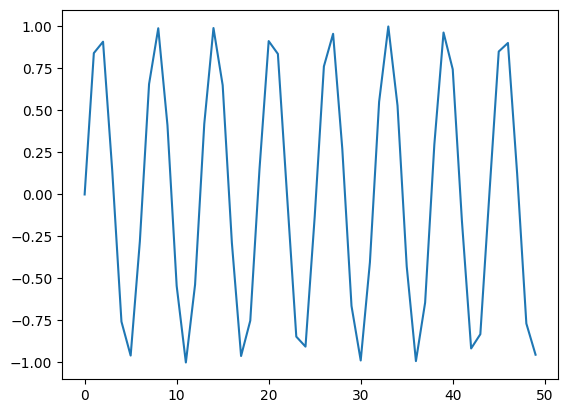

In [2]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)])
# Visualizing the sine wave we’ve just generated:
plt.plot(sin_wave[:50]) # plot the sine wave

In [4]:
X = []
Y = []
seq_len = 50
num_records = len(sin_wave) - seq_len
for i in range(num_records - 50):
	X.append(sin_wave[i:i+seq_len])
	Y.append(sin_wave[i+seq_len])
X = np.array(X)
X = np.expand_dims(X, axis=2)
Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

In [5]:
X.shape, Y.shape

((100, 50, 1), (100, 1))

In [6]:
X_val = []
Y_val = []
for i in range(num_records - 50, num_records):
	X_val.append(sin_wave[i:i+seq_len])
	Y_val.append(sin_wave[i+seq_len])
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)
Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

In [7]:
X_val.shape, Y_val.shape

((50, 50, 1), (50, 1))

In [8]:
learning_rate = 0.0001
nepoch = 2
T = 50 # length of sequence
hidden_dim = 100
output_dim = 1
bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10
# We will then define the weights of the network:
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

In [12]:
def sigmoid(x):
	return 1 / (1 + np.exp(-x))

In [16]:
for epoch in range(nepoch):
	# check loss on train
	loss = 0.0
	# do a forward pass to get prediction
	for i in range(Y.shape[0]):
		x, y = X[i], Y[i] # get input, output values of each record
		prev_s = np.zeros((hidden_dim, 1)) # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
		for t in range(T):
			new_input = np.zeros(x.shape) # we then do a forward pass for every timestep in the sequence
			new_input[t] = x[t] # for this, we define a single input for that timestep
			mulu = np.dot(U, new_input)
			mulw = np.dot(W, prev_s)
			add = mulw + mulu
			s = sigmoid(add)
			mulv = np.dot(V, s)
			prev_s = s
		# calculate error
		loss_per_record = (y - mulv)**2 / 2
		loss += loss_per_record
	loss = loss / float(y.shape[0])
	val_loss = 0.0
	for i in range(Y_val.shape[0]):
		x, y = X_val[i], Y_val[i]
		prev_s = np.zeros((hidden_dim, 1))
		for t in range(T):
			new_input = np.zeros(x.shape)
			new_input[t] = x[t]
			mulu = np.dot(U, new_input)
			mulw = np.dot(W, prev_s)
			add = mulw + mulu
			s = sigmoid(add)
			mulv = np.dot(V, s)
			prev_s = s
		loss_per_record = (y - mulv)**2 / 2
		val_loss += loss_per_record
	val_loss = val_loss / float(y.shape[0])
	print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)
	for i in range(Y.shape[0]):
		x, y = X[i], Y[i]
		layers = []
		prev_s = np.zeros((hidden_dim, 1))
		dU = np.zeros(U.shape)
		dV = np.zeros(V.shape)
		dW = np.zeros(W.shape)
		dU_t = np.zeros(U.shape)
		dV_t = np.zeros(V.shape)
		dW_t = np.zeros(W.shape)
		dU_i = np.zeros(U.shape)
		dW_i = np.zeros(W.shape)
		# forward pass
		for t in range(T):
			new_input = np.zeros(x.shape)
			new_input[t] = x[t]
			mulu = np.dot(U, new_input)
			mulw = np.dot(W, prev_s)
			add = mulw + mulu
			s = sigmoid(add)
			mulv = np.dot(V, s)
			layers.append({'s':s, 'prev_s':prev_s})
			prev_s = s
		# derivative of pred
		dmulv = (mulv - y)
		# backward pass
		for t in range(T):
			dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
			dsv = np.dot(np.transpose(V), dmulv)
			ds = dsv
			dadd = add * (1 - add) * ds
			dmulw = dadd * np.ones_like(mulw)
			dprev_s = np.dot(np.transpose(W), dmulw)
			for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
				ds = dsv + dprev_s
				dadd = add * (1 - add) * ds
				dmulw = dadd * np.ones_like(mulw)
				dmulu = dadd * np.ones_like(mulu)
				dW_i = np.dot(W, layers[t]['prev_s'])
				dprev_s = np.dot(np.transpose(W), dmulw)
				new_input = np.zeros(x.shape)
				new_input[t] = x[t]
				dU_i = np.dot(U, new_input)
				dU_t += dmulu * dU_i
				dW_t += dmulw * dW_i
			dV += dV_t
			dU += dU_t
			dW += dW_t
			if dU.max() > max_clip_value:
				dU[dU > max_clip_value] = max_clip_value
			if dV.max() > max_clip_value:
				dV[dV > max_clip_value] = max_clip_value
			if dW.max() > max_clip_value:
				dW[dW > max_clip_value] = max_clip_value
			if dU.min() < min_clip_value:
				dU[dU < min_clip_value] = min_clip_value
			if dV.min() < min_clip_value:
				dV[dV < min_clip_value] = min_clip_value
			if dW.min() < min_clip_value:
				dW[dW < min_clip_value] = min_clip_value
		# update
		U -= learning_rate * dU
		V -= learning_rate * dV
		W -= learning_rate * dW


Epoch:  1 , Loss:  [[124615.04934345]] , Val Loss:  [[62305.55941534]]
Epoch:  2 , Loss:  [[79697.09237464]] , Val Loss:  [[39846.966705]]


In [18]:
preds = []
for i in range(Y.shape[0]):
	x, y = X[i], Y[i]
	prev_s = np.zeros((hidden_dim, 1))
	for t in range(T):
		new_input = np.zeros(x.shape)
		new_input[t] = x[t]
		mulu = np.dot(U, new_input)
		mulw = np.dot(W, prev_s)
		add = mulw + mulu
		s = sigmoid(add)
		mulv = np.dot(V, s)
		prev_s = s
	preds.append(mulv)
preds = np.array(preds)

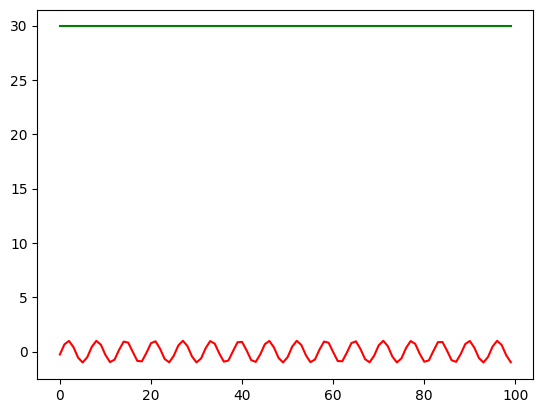

In [19]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

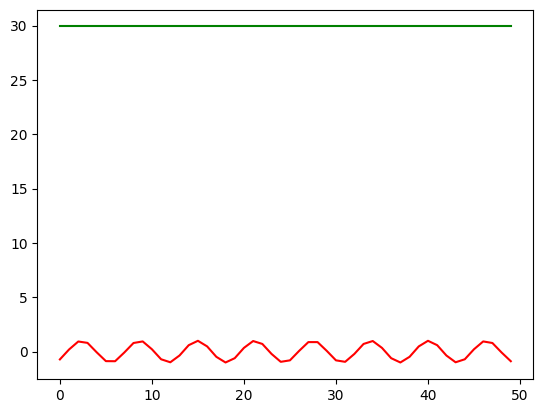

In [20]:
preds = []
for i in range(Y_val.shape[0]):
	x, y = X_val[i], Y_val[i]
	prev_s = np.zeros((hidden_dim, 1))
	for t in range(T):
		new_input = np.zeros(x.shape)
		new_input[t] = x[t]
		mulu = np.dot(U, new_input)
		mulw = np.dot(W, prev_s)
		add = mulw + mulu
		s = sigmoid(add)
		mulv = np.dot(V, s)
		prev_s = s
	preds.append(mulv)
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()

# Sentiment analysis using RNNs

In [ ]:
# %pip install tensorflow

In [41]:
import numpy as np
import tensorflow.compat.v1 as tf

In [24]:
with open('data/reviews.txt', 'r') as f:
    reviews = f.read()
with open('data/labels.txt', 'r') as f:
    labels = f.read()

In [25]:
reviews[:2000]

'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   \nstory of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is tu

In [26]:
from string import punctuation
all_text = ''.join([c for c in reviews if c not in punctuation])
reviews = all_text.split('\n')

all_text = ' '.join(reviews)
words = all_text.split()

In [27]:
all_text[:2000]

'bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life  such as  teachers   my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers   the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students  when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled          at           high  a classic line inspector i  m here to sack one of your teachers  student welcome to bromwell high  i expect that many adults of my age think that bromwell high is far fetched  what a pity that it isn  t    story of a man who has unnatural feelings for a pig  starts out with a opening scene that is a terrific example of absurd comedy  a formal orchestra audience is turned into an insane  violent m

In [ ]:
words[:100]

In [29]:
print(type(reviews), len(reviews), reviews[0],'last review:',reviews[25000])

<class 'list'> 25001 bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life  such as  teachers   my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers   the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students  when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled          at           high  a classic line inspector i  m here to sack one of your teachers  student welcome to bromwell high  i expect that many adults of my age think that bromwell high is far fetched  what a pity that it isn  t    last review: 


In [30]:
from collections import Counter
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

reviews_ints = []
for each in reviews:
    reviews_ints.append([vocab_to_int[word] for word in each.split()])

In [31]:
labels = labels.split('\n')
labels = np.array([1 if each == 'positive' else 0 for each in labels])

In [32]:
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 1
Maximum review length: 2514


In [33]:
non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review) != 0]
len(non_zero_idx)

25000

In [34]:
reviews_ints[-1]

[]

In [35]:
reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]
labels = np.array([labels[ii] for ii in non_zero_idx])

In [36]:
seq_len = 200
features = np.zeros((len(reviews_ints), seq_len), dtype=int)
for i, row in enumerate(reviews_ints):
    features[i, -len(row):] = np.array(row)[:seq_len]

In [ ]:
features[:10,:100]

In [38]:
split_frac = 0.8
split_idx = int(len(features)*0.8)
train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(20000, 200) 
Validation set: 	(2500, 200) 
Test set: 		(2500, 200)


In [39]:
lstm_size = 256
lstm_layers = 1
batch_size = 200
learning_rate = 0.001

In [42]:
n_words = len(vocab_to_int)

# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs')
    labels_ = tf.placeholder(tf.int32, [None, None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [43]:
# Size of the embedding vectors (number of units in the embedding layer)
embed_size = 300 

with graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_words, embed_size), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs_)

In [48]:
with graph.as_default():
    # Your basic LSTM cell
    lstm = tf.nn.rnn_cell.BasicLSTMCell(lstm_size)
    
    # Add dropout to the cell
    drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.nn.rnn_cell.MultiRNNCell([drop] * lstm_layers)
    
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

/var/folders/33/fpkrjvyx2xjbfj5j99fyh82c0000gn/T/ipykernel_95803/591128018.py:3: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm = tf.nn.rnn_cell.BasicLSTMCell(lstm_size)


In [49]:
with graph.as_default():
    outputs, final_state = tf.nn.dynamic_rnn(cell, embed,
                                             initial_state=initial_state)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [54]:
with graph.as_default():
    predictions = tf.layers.dense(outputs[:, -1], 1, activation=tf.sigmoid)
    cost = tf.losses.mean_squared_error(labels_, predictions)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

/var/folders/33/fpkrjvyx2xjbfj5j99fyh82c0000gn/T/ipykernel_95803/1823026628.py:2: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  predictions = tf.layers.dense(outputs[:, -1], 1, activation=tf.sigmoid)


In [55]:
with graph.as_default():
    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [56]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [57]:
epochs = 10

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)
        
        for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
            feed = {inputs_: x,
                    labels_: y[:, None],
                    keep_prob: 0.5,
                    initial_state: state}
            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
            
            if iteration%5==0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))

            if iteration%25==0:
                val_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(val_x, val_y, batch_size):
                    feed = {inputs_: x,
                            labels_: y[:, None],
                            keep_prob: 1,
                            initial_state: val_state}
                    batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
            iteration +=1
    saver.save(sess, "checkpoints/sentiment.ckpt")

2023-10-22 21:58:26.380293: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled


Epoch: 0/10 Iteration: 5 Train loss: 0.259
Epoch: 0/10 Iteration: 10 Train loss: 0.240
Epoch: 0/10 Iteration: 15 Train loss: 0.235
Epoch: 0/10 Iteration: 20 Train loss: 0.227
Epoch: 0/10 Iteration: 25 Train loss: 0.242
Val acc: 0.667
Epoch: 0/10 Iteration: 30 Train loss: 0.256
Epoch: 0/10 Iteration: 35 Train loss: 0.202
Epoch: 0/10 Iteration: 40 Train loss: 0.230
Epoch: 0/10 Iteration: 45 Train loss: 0.210
Epoch: 0/10 Iteration: 50 Train loss: 0.194
Val acc: 0.748
Epoch: 0/10 Iteration: 55 Train loss: 0.269
Epoch: 0/10 Iteration: 60 Train loss: 0.203
Epoch: 0/10 Iteration: 65 Train loss: 0.213
Epoch: 0/10 Iteration: 70 Train loss: 0.175
Epoch: 0/10 Iteration: 75 Train loss: 0.220
Val acc: 0.764
Epoch: 0/10 Iteration: 80 Train loss: 0.198
Epoch: 0/10 Iteration: 85 Train loss: 0.192
Epoch: 0/10 Iteration: 90 Train loss: 0.167
Epoch: 0/10 Iteration: 95 Train loss: 0.231
Epoch: 0/10 Iteration: 100 Train loss: 0.200
Val acc: 0.736
Epoch: 1/10 Iteration: 105 Train loss: 0.130
Epoch: 1/10 Ite

KeyboardInterrupt: 

In [ ]:
test_acc = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {inputs_: x,
                labels_: y[:, None],
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))